In [4]:
import os, codecs
import pandas as pd
import numpy as np

%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [5]:
!ls ../data/ -l

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [6]:
PATH = '../data/'

def bike_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s


# 共享单车停车点位（电子围栏）数据
bike_fence = pd.read_csv(PATH + 'gxdc_tcd_0.csv')
bike_fence['FENCE_LOC'] = bike_fence['FENCE_LOC'].apply(bike_fence_format)

# 共享单车订单数据
bike_order = pd.read_csv(PATH + '共享单车订单gxdc_dd.csv')
bike_order = bike_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

In [7]:
import geohash
bike_order['geohash'] = bike_order.apply(lambda x: 
                        geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=9), axis=1)

In [8]:
from geopy.distance import geodesic

bike_fence['MIN_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
bike_fence['MAX_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

bike_fence['MIN_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
bike_fence['MAX_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

bike_fence['FENCE_AREA'] = bike_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

bike_fence['FENCE_CENTER'] = bike_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

In [9]:
import geohash
bike_order['geohash'] = bike_order.apply(
    lambda x: geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=6), 
axis=1)

bike_fence['geohash'] = bike_fence['FENCE_CENTER'].apply(
    lambda x: geohash.encode(x[0], x[1], precision=6)
)

In [10]:
# bike_order
geohash.encode(24.521156, 118.140385, precision=6), \
geohash.encode(24.521156, 118.140325, precision=6)

('wsk52r', 'wsk52r')

In [11]:
bike_order['UPDATE_TIME'] = pd.to_datetime(bike_order['UPDATE_TIME'])
bike_order['DAY'] = bike_order['UPDATE_TIME'].dt.day.astype(object)
bike_order['DAY'] = bike_order['DAY'].apply(str)

bike_order['HOUR'] = bike_order['UPDATE_TIME'].dt.hour.astype(object)
bike_order['HOUR'] = bike_order['HOUR'].apply(str)
bike_order['HOUR'] = bike_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

bike_order['DAY_HOUR'] = bike_order['DAY'] + bike_order['HOUR']

# 按照经纬度聚合

In [12]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

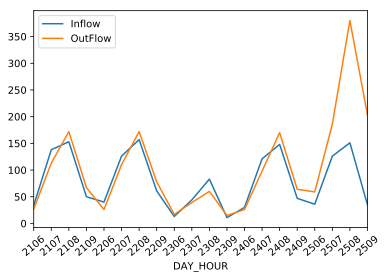

In [13]:
bike_inflow.loc['wsk52r'].plot()
bike_outflow.loc['wsk52r'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=40)
plt.legend(['Inflow', 'OutFlow'])

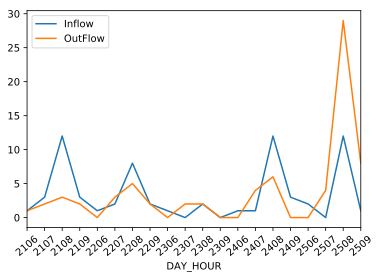

In [16]:
bike_inflow.loc['wsk596'].plot()
bike_outflow.loc['wsk596'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=40)
plt.legend(['Inflow', 'OutFlow'])

In [17]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

In [18]:
bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)
bike_fence['DENSITY'] = bike_fence['geohash'].map(bike_remain).fillna(0)

# 按照最近邻经纬度
思路： 按照订单计算与停车点的距离计算潮汐点；

In [20]:
import hnswlib
import numpy as np

p = hnswlib.Index(space='l2', dim=2)
p.init_index(max_elements=300000, ef_construction=1000, M=32)
p.set_ef(1024)
p.set_num_threads(14)

p.add_items(np.stack(bike_fence['FENCE_CENTER'].values))

In [21]:
index, dist = p.knn_query(bike_order[['LATITUDE','LONGITUDE']].values[:], k=1)
bike_order['fence'] = bike_fence.iloc[index.flatten()]['FENCE_ID'].values

In [22]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)

In [23]:
# bike_fence = bike_fence.set_index('FENCE_ID')
bike_density = bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA']

bike_density = bike_density.sort_values(ascending=False).reset_index()
bike_density = bike_density.fillna(0)

In [24]:
bike_density['label'] = '0'
bike_density.iloc[:100, -1] = '1'

bike_density['BELONG_AREA'] ='厦门'
bike_density = bike_density.drop(0, axis=1)

In [25]:
bike_density.columns = ['FENCE_ID', 'FENCE_TYPE', 'BELONG_AREA']
bike_density.to_csv('result.txt', index=None, sep='|')